## Метод опорных векторов (SVM)

**Пример решения классификатора soft-margin SVM**
1) Случайным образом добавим гиперплоскость разделяющую наблюдения на две группы
2) Определим отступ (margin) от каждого наблюдения до гиперплоскости.  Уравнение для линейного классификатора: $M_i(w⃗,b)=y_i(⟨w⃗,x⃗_i⟩−b)$
3) Определим функцию потерь Hinge loss: $Q =max(0,1- M_i) + \alpha(w^Tw)/2$
4) Найдем точку локального минимума функции потерь с помощью градиентного спуска
5) Найдем производную функции потерь: $ \nabla Q = \left\{ \begin{array}{ll} C w-yx & \textrm{, если }yw^Tx<1\\ C w & \textrm{, если }yw^Tx\geqslant 1 \end{array} \right. $
6) Обновим веса: $w = w – \eta\nabla Q$
, где $C$  — константа, параметр настройки метода, который позволяет регулировать отношение между максимизацией ширины разделяющей полосы и минимизацией суммарной ошибки, $\eta$ (эта) — шаг спуска (learning rate)
7) Итоговое выражение обновления весов: $w = w - \eta C w - yx$, если $yw^Tx<1$ и $w = w - \eta C w$, если $yw^Tx\geqslant1$


In [52]:
import numpy as np
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
plt.rcParams['figure.figsize'] = (8,6)
%matplotlib inline

from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

In [53]:
def newline(p1, p2, color=None): # функция отрисовки линии
    ax = plt.gca()
    xmin, xmax = ax.get_xbound()

    if(p2[0] == p1[0]):
        xmin = xmax = p1[0]
        ymin, ymax = ax.get_ybound()
    else:
        ymax = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmax-p1[0])
        ymin = p1[1]+(p2[1]-p1[1])/(p2[0]-p1[0])*(xmin-p1[0])

    l = mlines.Line2D([xmin,xmax], [ymin,ymax], color=color)
    ax.add_line(l)
    return l

In [127]:
'''
1) Cоздаем функцию add_bias_feature(a), которая автоматически расширяет вектор объектов, добавляя в конец каждого вектора число 1.
Это нужно для того, чтобы «забыть» про свободный член b.
Выражение w^Tx-b эквивалентно выражению w_1x_1+w_2x_2+…+w_nx_n+w_0*1.
Мы условно считаем, что единица — это последняя компонента вектора для всех векторов x, а w_0=-b.
Теперь настройку весов w и w_0 будем производить одновременно.
'''

def add_bias_feature(a):
    a_extended = np.zeros((a.shape[0],a.shape[1]+1))
    a_extended[:,:-1] = a
    a_extended[:,-1] = int(1)
    return a_extended

In [95]:
class CustomSVM(object):

    __class__ = "CustomSVM"
    __doc__ = """
    This is an implementation of the SVM classification algorithm
    Note that it works only for binary classification

    #############################################################
    ######################   PARAMETERS    ######################
    #############################################################

    etha: float(default - 0.01)
        Learning rate, gradient step

    alpha: float, (default - 0.1)
        Regularization parameter in 0.5*alpha*||w||^2

    epochs: int, (default - 200)
        Number of epochs of training

    #############################################################
    #############################################################
    #############################################################
    """

    '''
    2) далее опишем сам классификатор. Он имеет внутри себя функции инициализации init(),
    обучения fit(), предсказания predict(), нахождения лосс функции hinge_loss()
    и нахождения общей лосс функции классического алгоритма с мягким зазором soft_margin_loss().

    3) при инициализации вводятся 3 гиперпараметра: _etha – шаг градиентного спуска eta,
     _С – коэффициент быстроты пропорционального уменьшения весов (перед квадратичным слагаемым
     в функции потерь, _epochs – количество эпох обучения.
    '''

    def __init__(self, etha=0.01, C=0.1, epochs=200):
        # количество циклов обучения
        self._epochs = epochs
        # learning rate
        self._etha = etha
        #
        self._C = C
        # вектор весов
        self._w = None
        self.history_w = []
        self.train_errors = None
        self.val_errors = None
        self.train_loss = None
        self.val_loss = None


    '''
    4) при обучении для каждой эпохи обучающей выборки (X_train, Y_train) мы будем брать по одному элементу из выборки,
    вычислять зазор между этим элементом и положением гиперплоскости в данный момент времени.
    Далее в зависимости от величины этого зазора мы будем изменять веса алгоритма с помощью градиента функции потерь Q.
    Заодно будем вычислять значение этой функции на каждой эпохе и сколько раз мы изменяем веса за эпоху.
    Перед началом обучения убедимся, что в функцию обучения пришло действительно не больше двух разных меток класса.
    Перед настройкой весов происходит их инициализация с помощью нормального распределения.
    '''


    def fit(self, X_train, Y_train, X_val, Y_val, verbose=False): #arrays: X; Y =-1,1
        if len(set(Y_train)) != 2 or len(set(Y_val)) != 2:
            raise ValueError("Number of classes in Y is not equal 2!")
        # добавим в конец матриц признаков X_train и X_val колонку с константным значением 1
        X_train = add_bias_feature(X_train)
        X_val = add_bias_feature(X_val)
        # случайным образом выберем 3 значения весов, которые положим в вектор весов _w
        self._w = np.random.normal(loc=0, scale=0.05, size=X_train.shape[1])
        # сохраним веса для истории
        self.history_w.append(self._w)
        train_errors = []
        val_errors = []
        train_loss_epoch = []
        val_loss_epoch = []

        for epoch in range(self._epochs):
            tr_err = 0
            val_err = 0
            tr_loss = 0
            val_loss = 0
            for i,x in enumerate(X_train):
                # вычисляем зазор между каждым элементом и гиперплоскостью (см. уравнение для линейного классификатора)
                margin = Y_train[i]*np.dot(self._w,X_train[i])
                # классифицируем верно
                if margin >= 1:
                    # обновим веса (см. итоговое выражение обновления весов)
                    self._w = self._w - self._etha*self._C*self._w/self._epochs
                    # обновим значение функции потерь
                    tr_loss += self.soft_margin_loss(X_train[i],Y_train[i])
                # классифицируем неверно или попадаем на полосу разделения при 0<m<1
                else:
                    # обновим веса (см. итоговое выражение обновления весов)
                    self._w = self._w +\
                    self._etha*(Y_train[i]*X_train[i] - self._C*self._w/self._epochs)
                    # обновим счетчик наблюдений, которые попадают на гиперплоскость
                    tr_err += 1
                    # обновим значение функции потерь
                    tr_loss += self.soft_margin_loss(X_train[i],Y_train[i])
                self.history_w.append(self._w)
            # проверим веса на валидационной выборке
            for i,x in enumerate(X_val):
                # найдем значение функции потерь
                val_loss += self.soft_margin_loss(X_val[i], Y_val[i])
                # обновим счетчик наблюдений, которые попадают на гиперплоскость
                val_err += (Y_val[i]*np.dot(self._w,X_val[i])<1).astype(int)
            if verbose:
                print('epoch {}. Errors={}. Mean Hinge_loss={}'\
                      .format(epoch,err,loss))
            train_errors.append(tr_err)
            val_errors.append(val_err)
            train_loss_epoch.append(tr_loss)
            val_loss_epoch.append(val_loss)
        self.history_w = np.array(self.history_w)
        self.train_errors = np.array(train_errors)
        self.val_errors = np.array(val_errors)
        self.train_loss = np.array(train_loss_epoch)
        self.val_loss = np.array(val_loss_epoch)


    # используем полученные веса для построения гиперплосткости на тестовой выборке
    def predict(self, X:np.array) -> np.array:
        y_pred = []
        X_extended = add_bias_feature(X)
        for i in range(len(X_extended)):
            y_pred.append(np.sign(np.dot(self._w,X_extended[i])))
        return np.array(y_pred)


    def hinge_loss(self, x, y):
        return max(0,1 - y*np.dot(x, self._w))


    def soft_margin_loss(self, x, y):
        return self.hinge_loss(x,y)+self._C*np.dot(self._w, self._w)

In [110]:
# Проверим, что наш написанный алгоритм работает на каком-нибудь игрушечном наборе данных.
# Возьмем датасет Iris. Подготовим данные. Обозначим классы 1 и 2 как +1, а класс 0 как -1.

# блок подготовки данных
iris = load_iris()
X = iris.data
Y = iris.target
print(X.shape)
print(Y.shape)

(150, 4)
(150,)


In [111]:
# С помощью алгоритма PCA оптимальным образом сократим пространство 4-х признаков
# до 2-х с минимальными потерями данных (нам будет проще наблюдать за обучением и результатом).

pca = PCA(n_components=2)
X = pca.fit_transform(X)
Y = (Y > 0).astype(int)*2-1
print(X.shape)
print(Y.shape)

(150, 2)
(150,)


In [112]:
# Далее разделим на обучающую и валидационную выборку. Обучим на трейн выборке,
# прогнозируем и проверяем на валидационной.

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(90, 2)
(60, 2)
(90,)
(60,)


In [113]:
X_train[:3]

array([[ 1.38876613, -0.20439933],
       [-2.35575405, -0.03728186],
       [-2.50666891, -0.14601688]])

[68 32 21 21 18 15 11  7  7  7  5  6  5  5  6  5  6  5  5  6  5  6  5  6
  5  5  6  5  6  4  4  3  3  2  3  2  3  3  2  3  3  1  2  1  2  1  2  1
  1  2  1  2  1  2  1  1  2  1  2  1  2  1  1  2  1  2  1  2  1  1  2  1
  2  1  2  1  1  2  1  2  1  2  1  1  2  1  2  1  2  1  1  2  1  2  1  2
  1  1  2  1  2  1  2  1  1  2  1  2  1  2  1  1  2  1  2  1  2  1  1  2
  1  2  1  2  1  1  2  1  2  1  2  1  1  2  1  2  1  2  1  1  2  1  2  1
  2  1  1  2  1  0]
[ 1.11455187 -0.84433993  1.37319107]


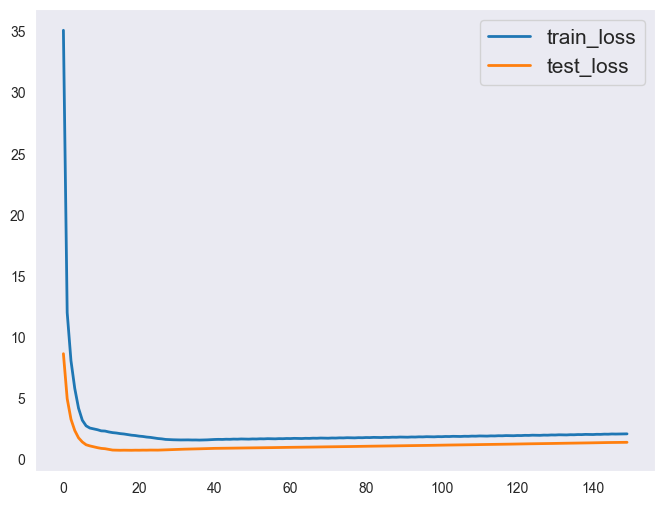

In [114]:
# Подберем коэффициенты обучения таким образом, чтобы лосс функция падала.
# Во время обучения будем смотреть на лосс функцию обучающей и валидационной выборки.

# блок инициализиции и обучения
svm = CustomSVM(etha=0.005, C=0.006, epochs=150)
svm.fit(X_train, Y_train, X_test, Y_test)

print(svm.train_errors)
print(svm._w)

plt.plot(svm.train_loss, linewidth=2, label='train_loss')
plt.plot(svm.val_loss, linewidth=2, label='test_loss')
plt.grid()
plt.legend(prop={'size': 15})
plt.show()

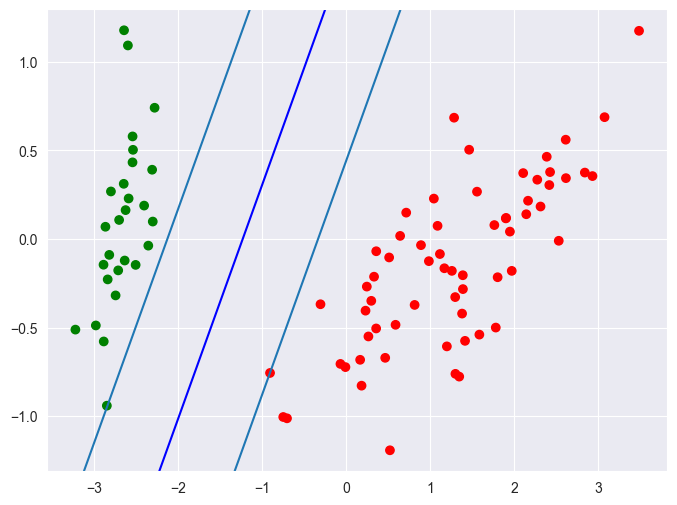

In [117]:
# построим график разделяющей гиперплоскости для тренировочной выборки
d = {-1:'green', 1:'red'}
plt.scatter(X_train[:,0], X_train[:,1], c=[d[y] for y in Y_train])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue')
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0])
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0])
plt.show()

Количество ошибок для валидационной выборки:  0


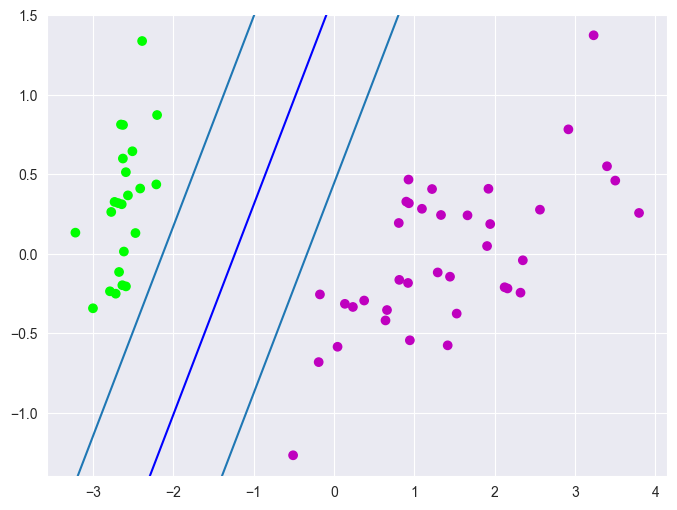

In [118]:
# построим график разделяющей гиперплоскости для валидационной выборки
y_pred = svm.predict(X_test)
y_pred[y_pred != Y_test] = -100
print('Количество ошибок для валидационной выборки: ', (y_pred == -100).astype(int).sum())
d1 = {-1:'lime', 1:'m', -100: 'black'}
plt.scatter(X_test[:,0], X_test[:,1], c=[d1[y] for y in y_pred])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue')
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0])
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0])
plt.show()

In [122]:
# Отлично! Наш алгоритм справился с линейно разделимыми данными.
# Теперь заставим его отделить классы 0 и 1 от класса 2.

# блок подготовки данных
iris = load_iris()
X = iris.data
Y = iris.target

pca = PCA(n_components=2)
X = pca.fit_transform(X)
Y = (Y == 2).astype(int)*2-1 # [0,1,2] --> [False,False,True] --> [0,1,1] --> [0,0,2] --> [-1,1,1]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

In [123]:
X_train[:3]

array([[ 1.38876613, -0.20439933],
       [-2.35575405, -0.03728186],
       [-2.50666891, -0.14601688]])

[53 43 41 38 33 33 31 29 27 26 27 25 24 24 24 23 22 22 22 22 22 22 22 22
 20 21 20 20 19 17 19 17 17 17 17 17 17 17 15 17 17 17 15 17 17 17 16 15
 15 17 17 17 17 15 17 17 17 14 15 14 15 14 15 15 14 15 15 13 14 13 13 12
 13 12 13 12 13 12 12 13 12 13 12 13 12 11 12 12 13 12 12 11 10 13 12 10
 13 12 10 13 12 10 13 12 11 12 12 11 12 10 12 13 10 12 13 10 12 13 11 12
 12 11 12 12 11 12 12 11 12 10 11 12  9 10 12 10 11 10 10 10 11 10 10 11
 10 10 10  9 10 10]
[ 4.0898999  -4.06416337 -5.78460823]


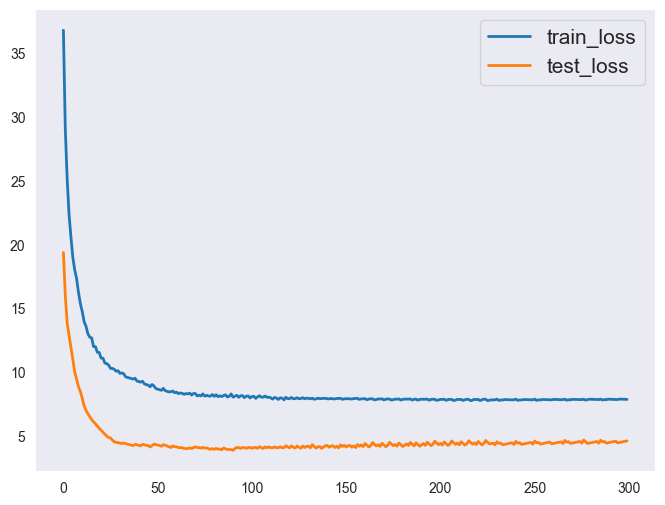

In [124]:
# блок инициализиции и обучения
svm = CustomSVM(etha=0.03, C=0.0001, epochs=300)
svm.fit(X_train, Y_train, X_test, Y_test)

print(svm.train_errors[:150]) # numbers of error in each epoch
print(svm._w) # w0*x_i[0]+w1*x_i[1]+w2=0

plt.plot(svm.train_loss, linewidth=2, label='train_loss')
plt.plot(svm.val_loss, linewidth=2, label='test_loss')
plt.grid()
plt.legend(prop={'size': 15})
plt.show()

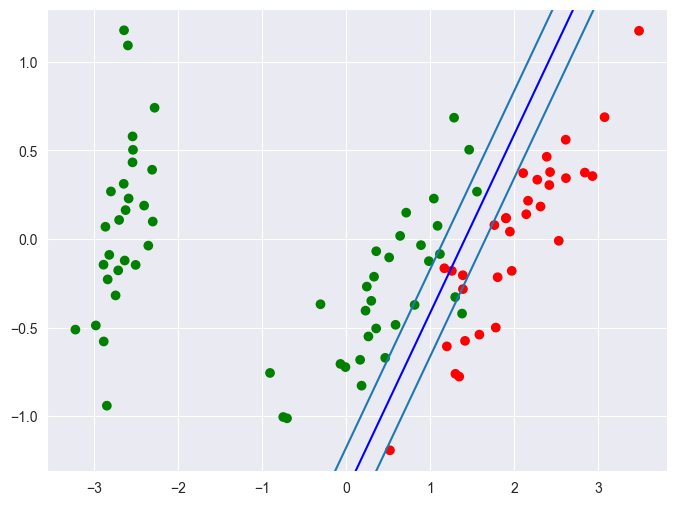

In [125]:
d = {-1:'green', 1:'red'}
plt.scatter(X_train[:,0], X_train[:,1], c=[d[y] for y in Y_train])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue') # в w0*x_i[0]+w1*x_i[1]+w2*1=0 поочередно
                                                        # подставляем x_i[0]=0, x_i[1]=0
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=1
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=-1
plt.show()

Количество ошибок для отложенной выборки:  2


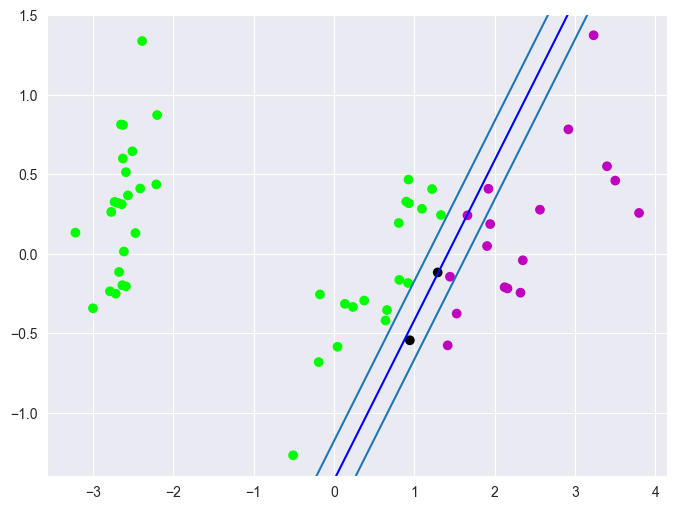

In [126]:
# предсказываем после обучения
y_pred = svm.predict(X_test)
y_pred[y_pred != Y_test] = -100 # find and mark classification error
print('Количество ошибок для отложенной выборки: ', (y_pred == -100).astype(int).sum())
d1 = {-1:'lime', 1:'m', -100: 'black'} # black = classification error
plt.scatter(X_test[:,0], X_test[:,1], c=[d1[y] for y in y_pred])
newline([0,-svm._w[2]/svm._w[1]],[-svm._w[2]/svm._w[0],0], 'blue')
newline([0,1/svm._w[1]-svm._w[2]/svm._w[1]],[1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=1
newline([0,-1/svm._w[1]-svm._w[2]/svm._w[1]],[-1/svm._w[0]-svm._w[2]/svm._w[0],0]) #w0*x_i[0]+w1*x_i[1]+w2*1=-1
plt.show()